
<div style="background:#5DADE2;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style="color:#fff"><font size="6">Pronóstico de Series de Tiempo con Python (Arima, LSTM, Prophet)</font></h4>
    </strong>
</div>

En el siguiente notebook se analiza la serie de tiempo de producción de cerveza de Australia. Se aplican los modelos ARIMA, SARIMA. También, se prueba el ajuste con Prophet y finalmente, se crea una Red Neuronal Recurrente.
La serie seleccionada para la realización del presente proyecto corresponde a la producción mensual de cerveza en Australia en unidades de volumen para el periodo: enero de 1956 - agosto de 1995 (un total de 476 observaciones).


<div style="background:#0B4AAB;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 5>1.Importaciones de librerias</font></h4>
    </strong>
</div><br>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler

#from prophet import Prophet

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

In [2]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.1


In [4]:

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM




Using TensorFlow backend.



<div style="background:#0B4AAB;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 5>2.Importando datos</font></h4>
    </strong>
</div><br>

In [5]:
url = 'https://raw.githubusercontent.com/sergiomora03/AdvancedMethodsDataAnalysis/master/datasets_56102_107707_monthly-beer-production-in-austr.csv'
data = pd.read_csv(url)
data.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [6]:
#Descripción de la base de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


<div style="background:#0B4AAB;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 5>3.Transformación de datos</font></h4>
    </strong>
</div><br>

De acuerdo a lo observado en la data original es necesario transformar la variable **Month** a formato fecha

In [7]:
data.Month = pd.to_datetime(data.Month)
data.set_index('Month', inplace=True)
data.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [8]:
#Producción en logaritmo
data['Log_Production']=np.log(data['Monthly beer production'])

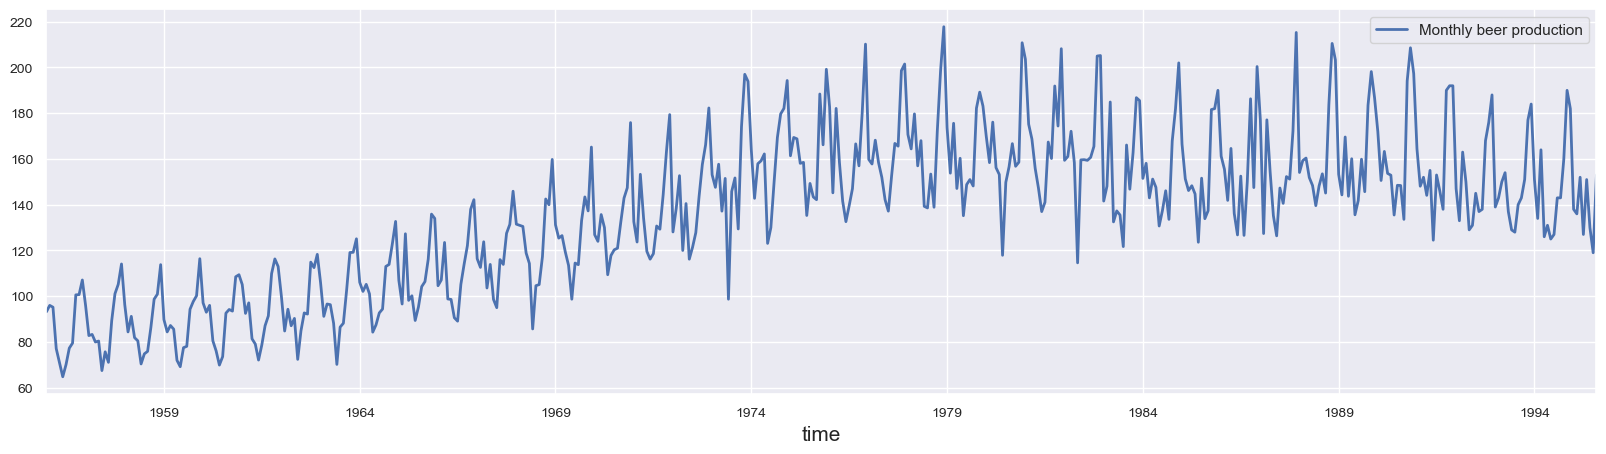

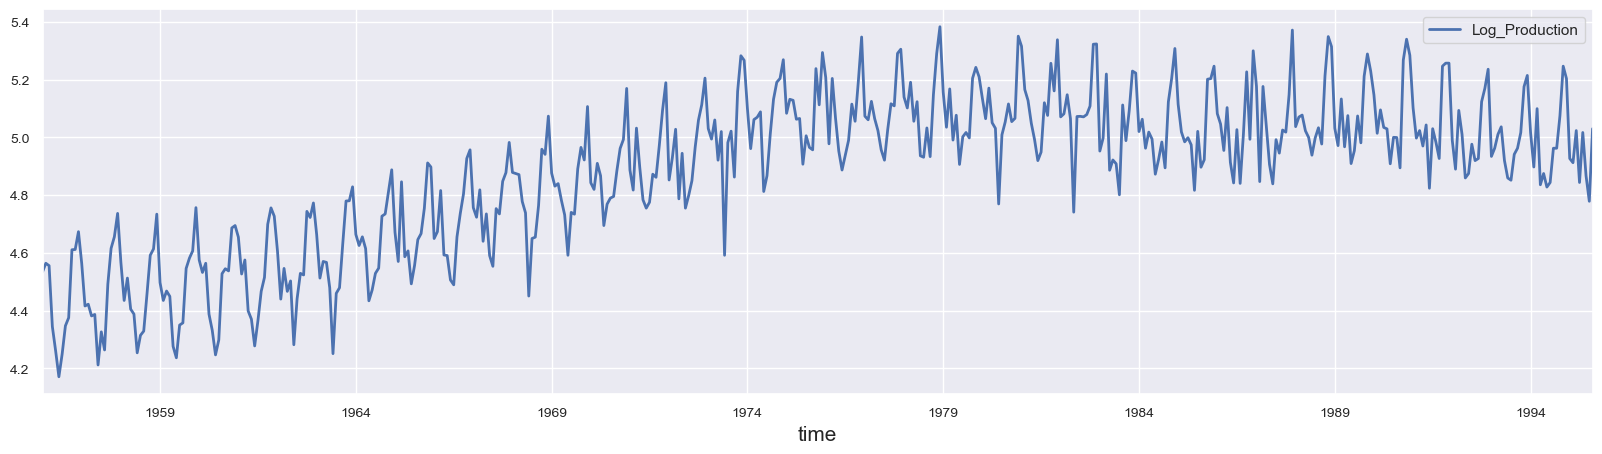

In [9]:
#Evolución de producción de cerveza en Australia durante el periodo de análisis (niveles y logaritmo)
data[['Monthly beer production']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);
data[['Log_Production']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

Los anteriores gráficos permiten observar la evolución de la producción de cerveza en Australia para el periodo de análisis.

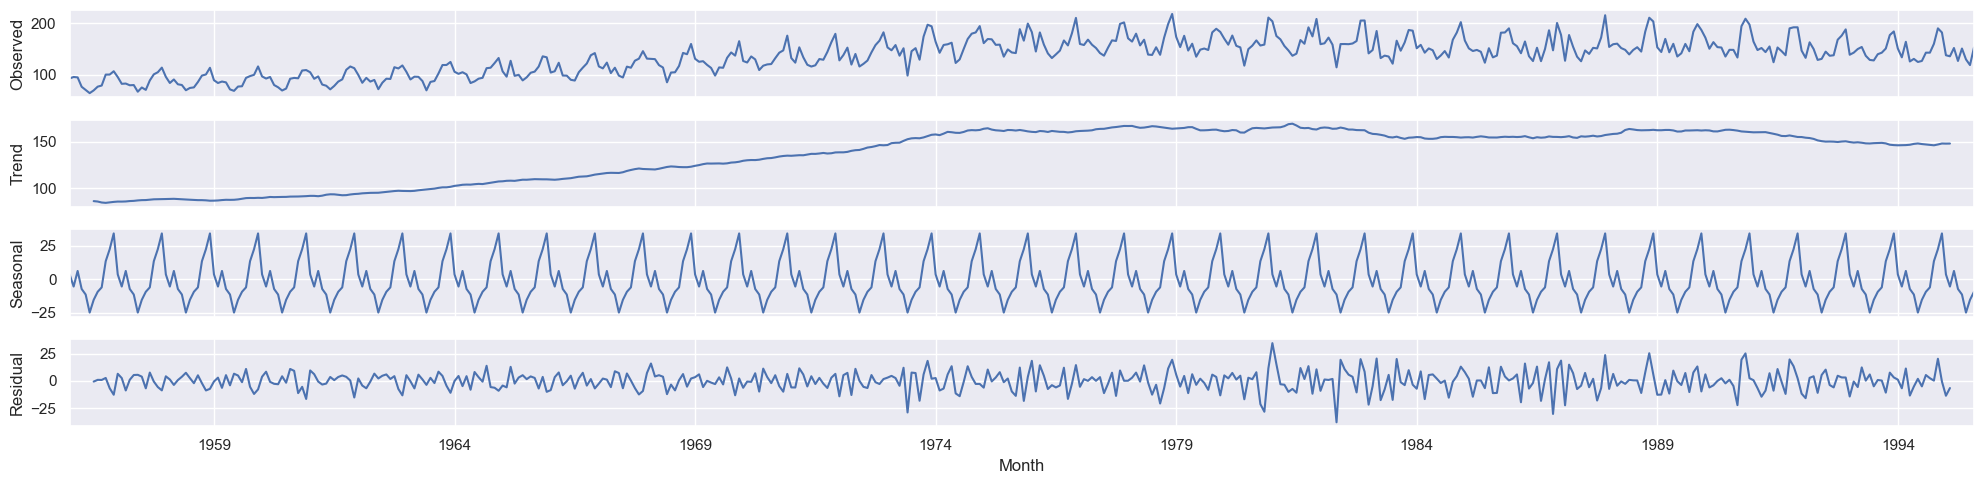

In [8]:
#seasonal_decompose de la biblioteca statsmodels en Python para descomponer una serie temporal en sus componentes observados, tendencia, estacional y residual. 
#Además, se define una función llamada plotseasonal para visualizar estos componentes.
#res = seasonal_decompose(data['Monthly beer production'], model='additive',freq=12)
res = seasonal_decompose(data['Monthly beer production'], model='additive', period=12)


def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()


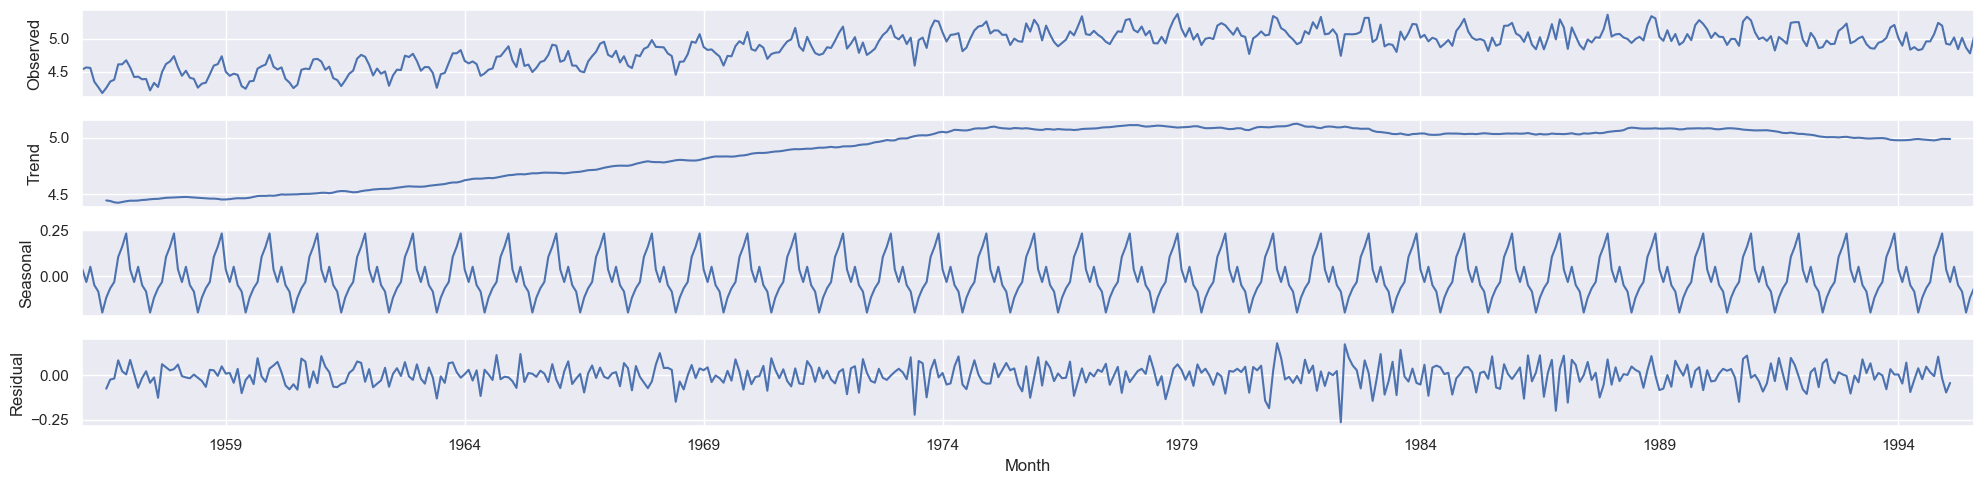

In [9]:
res = seasonal_decompose(data['Log_Production'], model='additive', period=12)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()

A partir de los gráficos de la producción de cerveza (tanto en niveles como en logaritmo), se puede observar lo siguiente en relación con el comportamiento de la serie y sus componentes:

1) Hasta el año 1974 se registra un crecimiento importante de la producción de cerveza en el país, mostrando un tendencia positiva durante estos primeros años de análisis, para luego estabilizarse y tener una ligera disminución a principios de la decada de los 80´s (tendencia negativa). La presencia de diferentes tendencias en el tiempo, indican inicialmente que la serie no es estacionaria.

2) La serie tiene un marcado componente estacional, que consiste en un aumento de la producción de cerveza cada 12 meses, especificamente a finales del año (noviembre - diciembre) para luego disminuir a partir del mes de enero del siguiente año. Esta dinámica es consistente con la temporada de verano de Australia.

3) El cambio en la amplitud del cada ciclo y la presencia de un componente aleatorio en el periodo de análisis, indican que la producción de cerveza ha recibido diferentes choques (oferta o demanda) que ha cambiado su dinámica en el tiempo y, además, puede indicar problemas de heterocedasticidad en la serie.


<div style="background:#0B4AAB;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 5>4.Análisis de estacionariedad</font></h4>
    </strong>
</div><br>

In [11]:
beer=data['Monthly beer production']
Log_beer=data['Log_Production']

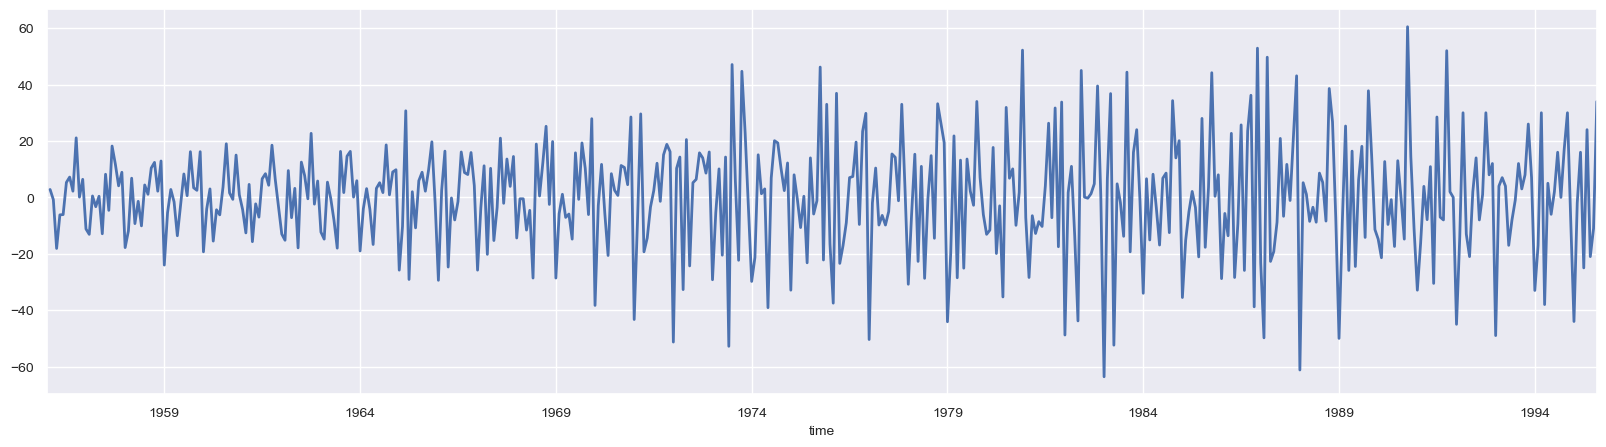

In [12]:
#Primera diferencia de la serie (niveles)
#En resumen, el código toma un DataFrame llamado beer, 
#calcula las diferencias entre los valores sucesivos de sus columnas y 
#luego genera un gráfico de líneas para visualizar esas diferencias
beer.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=10);

<AxesSubplot:xlabel='Month'>

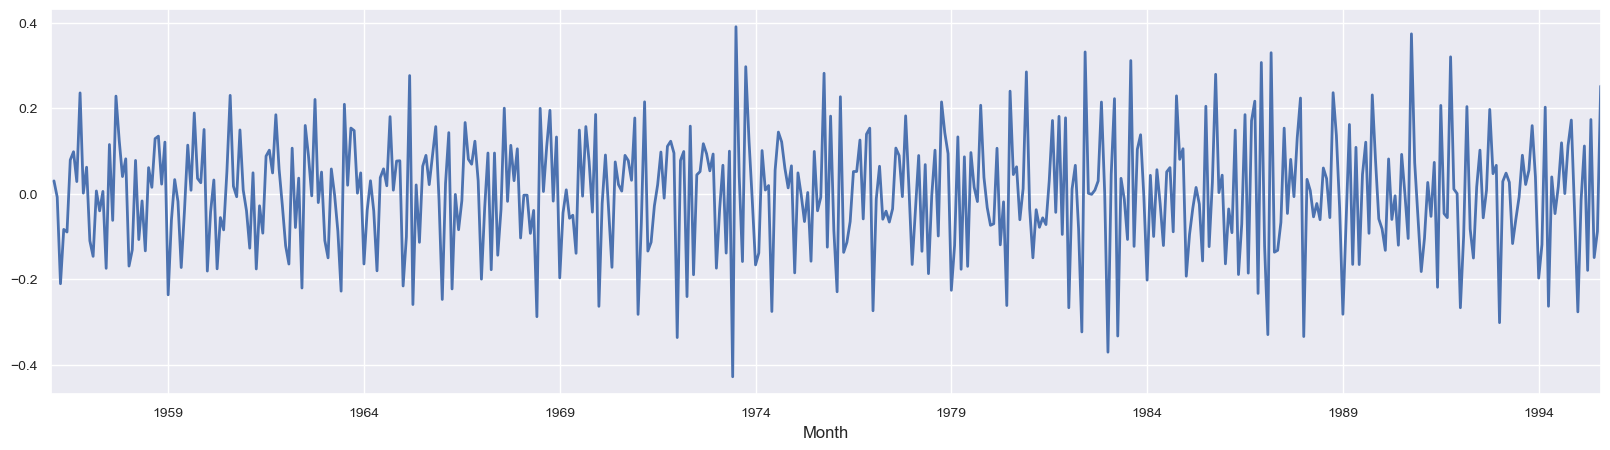

In [14]:
#Primera diferencia de la serie (logaritmo)
Log_beer.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)

Una vez se diferencian las series se observa que la tendencia desaparece. Adicionalmente, con la transformación de logaritmo parece mejorar el problema de varianza no constante. Por consiguiente, el ejercicio de análisis y estimación se realizará con **la serie en logaritmo**.



#### Prueba de Dickey- Fuller
Para realizar una verificación formal de la estacionariedad de la serie.

In [15]:
#Prueba Dickey- Fuller
result = adfuller(data['Log_Production'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.800769
p-value: 0.058164
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


Los resultados de la prueba de Dickey- Fuller confirman que, con un nivel de significancia del 5%, la serie de producción de cerveza no es estacionaria.

In [16]:
#Prueba Dickey- Fuller - primera diferencia
result = adfuller(data['Log_Production'].diff().iloc[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.869646
p-value: 0.000040
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


Los resultados de la prueba de Dickey- Fuller confirman que, con un nivel de significancia del 5%, la serie de producción de cerveza diferenciada si es estacionaria.

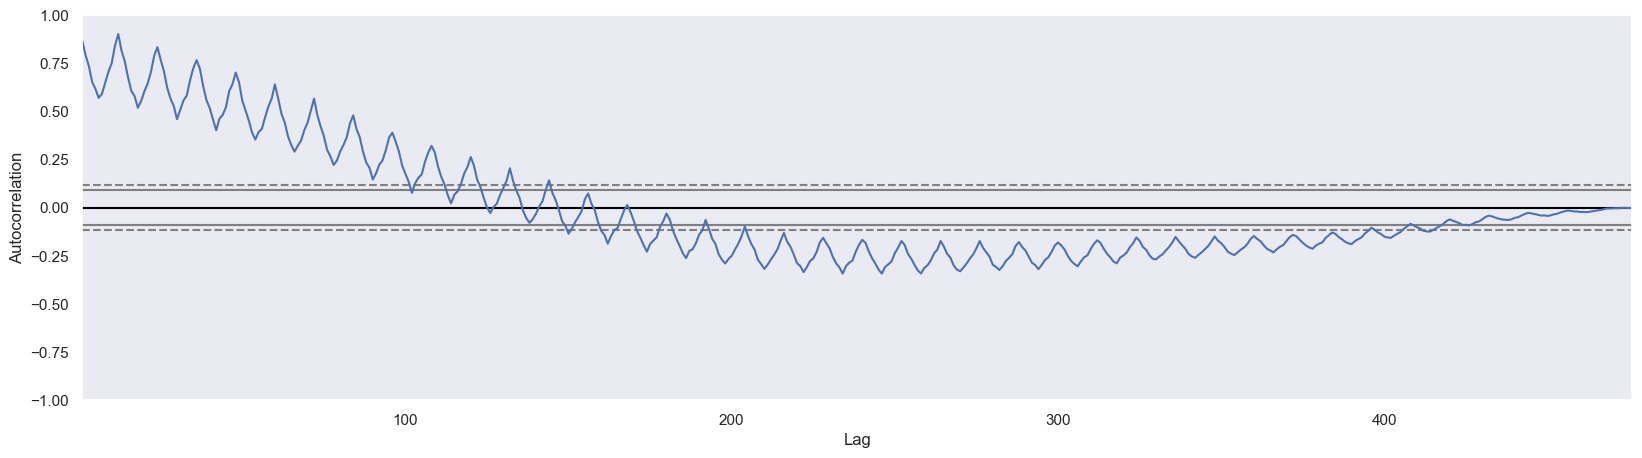

In [17]:
#Autocorrelación de la serie en análisis
plt.figure(figsize=(20,5))
pd.plotting.autocorrelation_plot(data['Log_Production']);

Como se comprobó en el test de raíz unitaria, esta caída lenta en la función de autocorrelación simple, da indicios que la serie es no estacionaria.

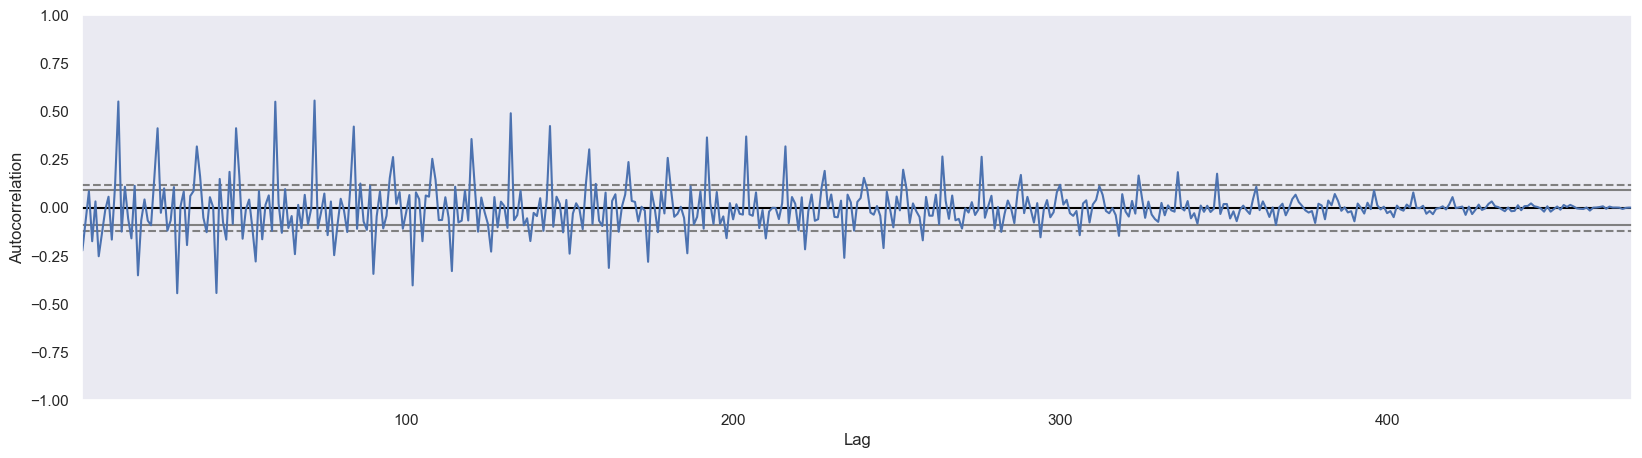

In [18]:
#Autocorrelación de la primera diferencia de la serie en análisis
plt.figure(figsize=(20,5))
pd.plotting.autocorrelation_plot(data['Log_Production'].diff().iloc[1:]);

c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


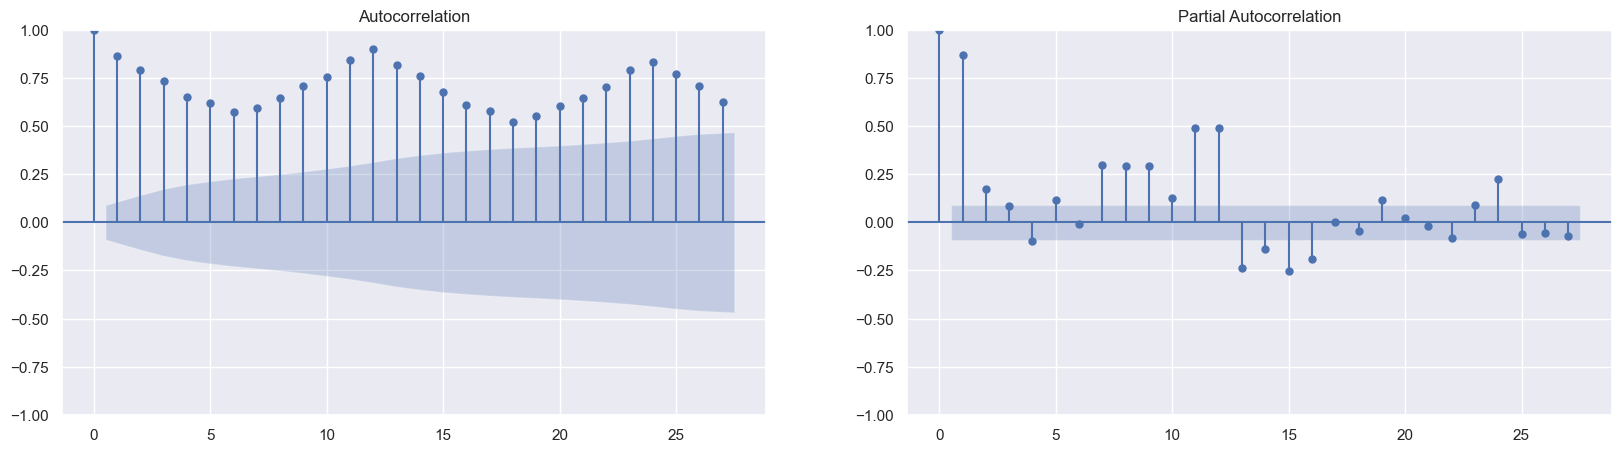

In [19]:
#Autocorrelación simple y parcial serie producción cerveza
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(data['Log_Production'], ax=ax[0])
plot_pacf(data['Log_Production'], ax=ax[1])
plt.show()

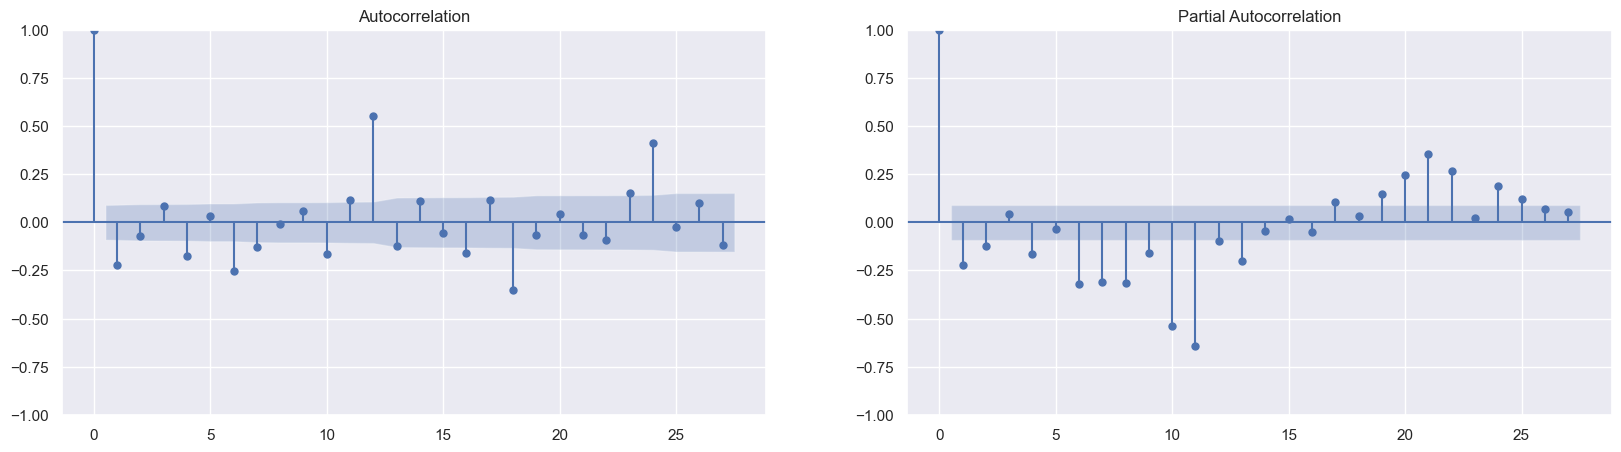

In [20]:
#Autocorrelación simple y parcial primera diferencia de serie producción cerveza
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(data['Log_Production'].diff().iloc[1:], ax=ax[0])
plot_pacf(data['Log_Production'].diff().iloc[1:], ax=ax[1])
plt.show()


<div style="background:#0B4AAB;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 5>5.Aplicación de modelos de predicción</font></h4>
    </strong>
</div><br>

En la presente sección se procede a la estimación de diferentes modelos de predicción: ARIMA, SARIMA, Prophet y una red reuronal recurente con una celda LSTM.

## Modelo ARIMA

####  Selección proceso ARIMA a estimar

In [33]:
#En resumen, esta función ARIMA toma dos parámetros (órdenes p y q), 
#ajusta un modelo ARIMA iterativamente en el conjunto de prueba y devuelve el RMSE como medida de rendimiento. 
#La iteración y actualización del historial se realizan para cada punto en el conjunto de prueba.

X = data['Log_Production'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]

#p y q, que representan los órdenes de los componentes autoregresivos y de media móvil del modelo ARIMA.
def ARIMA_FUNCTION(p,q):
	for t in range(len(test)):
		model_1 = ARIMA(history, order=(p,1,q))
		model_fit_1 = model_1.fit(disp=0)
		output = model_fit_1.forecast()
		yhat = output[0]
		predictions.append(yhat)
		obs = test[t]
		history.append(obs)
	return mean_squared_error(test, predictions)**0.5

In [36]:
import statsmodels.api as sm

results = []

for i in range(3):
    for j in range(4):
        if (i > j or i == 0) and (i - j < 3):
            predictions = list()
            history = [x for x in train]  # Asegúrate de que 'train' esté definido antes de este bucle
            model = sm.tsa.ARIMA(history, order=(i, 0, j))
            fit_model = model.fit()  # No hay 'disp' en el método fit
            results.append([i, j, fit_model])
            print((i, j))


(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(2, 0)
(2, 1)


Escenarios para evaluar los procesos *ARIMA*, en estos casos en todos los modelos utilizamos 1 Diferenciación, el primer parámetro representa el proceso AR, el segundo corresponde al MA

In [37]:
results

[[0, 0, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfcd8a88>],
 [0, 1, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfb337c8>],
 [0, 2, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfe03788>],
 [0, 3, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfe1bf88>],
 [1, 0, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfe38848>],
 [2, 0, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfe57048>],
 [2, 1, <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x22cbfe6eb08>]]

De acuerdo a los RMSE obtenidos para cada modelo evaluado en los procesos ARIMA, el mejor modelo es el ARIMA (0,1,2) con un RMSE correspondiente a 0.12223215571124342

#### Estimación modelo

In [39]:
model = ARIMA(train, order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  428
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 281.844
Date:                Tue, 06 Feb 2024   AIC                           -557.688
Time:                        15:08:58   BIC                           -545.518
Sample:                             0   HQIC                          -552.881
                                - 428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4638      0.047     -9.884      0.000      -0.556      -0.372
ma.L2         -0.4294      0.052     -8.309      0.000      -0.531      -0.328
sigma2         0.0156      0.001     13.781      0.0

#### Análisis de residuales

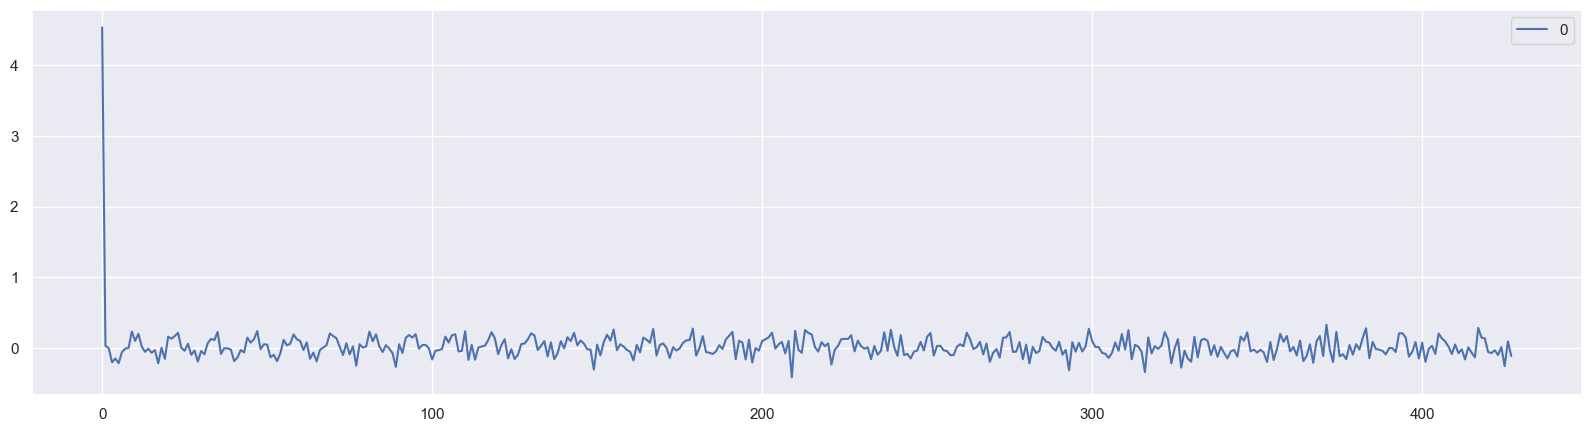

In [41]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(20,5))
plt.show()

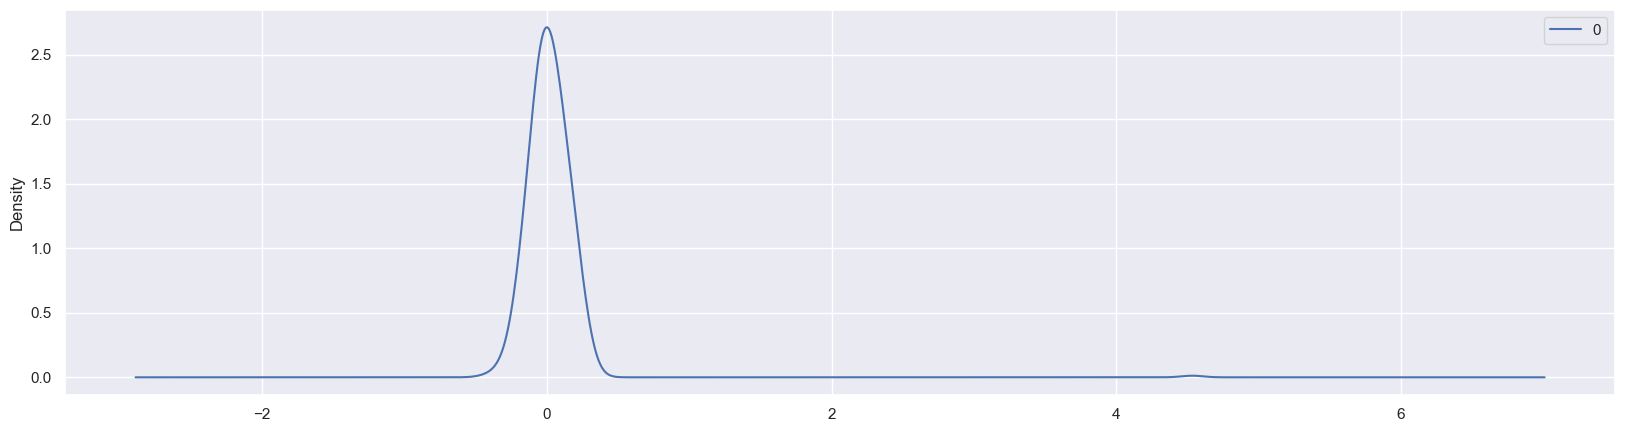

                0
count  428.000000
mean     0.023284
std      0.251486
min     -0.415004
25%     -0.068301
50%      0.008215
75%      0.100232
max      4.534748


In [42]:
residuals.plot(kind='kde', figsize=(20,5))
plt.show()
print(residuals.describe())

De acuerdo a los gráficos de los residuales podemos observar que el proceso tiene media constante, centrada alrededor de cero y varianza constante. Tambien, graficamente parece ajustarse a una distribución Normal, sin embargo validamos esto con una prueba de normalidad 

In [43]:
print("KS P-value = "+str(round(stats.kstest(residuals, 'norm')[1], 10)))

KS P-value = 0.0


Según los resultados del test de Kolmogorov Smirnoff con un nivel de significancia del 5% no podemos concluir que los residuales se ajustan a una distribución normal.

#### Rolling Forecast

In [45]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model_1 = ARIMA(history, order=(0,1,2))
    model_fit_1 = model_1.fit()
    output = model_fit_1.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=4.996508, expected=4.927254
predicted=5.008252, expected=5.247024
predicted=5.166711, expected=5.257495
predicted=5.112389, expected=5.257495
predicted=5.151598, expected=4.990433
predicted=5.002025, expected=4.890349
predicted=5.011440, expected=5.093750
predicted=5.104221, expected=5.010635
predicted=5.017938, expected=4.859812
predicted=4.972977, expected=4.875197
predicted=4.988741, expected=4.976734
predicted=5.024908, expected=4.919981
predicted=4.973031, expected=4.927254
predicted=4.993875, expected=5.123964
predicted=5.084818, expected=5.170484
predicted=5.074631, expected=5.236442
predicted=5.125369, expected=4.934474
predicted=4.950937, expected=4.962845
predicted=5.040542, expected=5.010635
predicted=5.019216, expected=5.036953
predicted=5.041821, expected=4.919981
predicted=4.968254, expected=4.859812
predicted=4.962485, expected=4.852030
predicted=4.949599, expected=4.941642
predicted=4.993429, expected=4.962845
predicted=4.980238, expected=5.017280
predicted=5.

c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4.892486, expected=4.875197
predicted=4.990132, expected=4.828314
predicted=4.910286, expected=4.844187
predicted=4.944558, expected=4.962845
predicted=4.983071, expected=4.962845
predicted=4.964151, expected=5.075174
predicted=5.033155, expected=5.247024
predicted=5.101096, expected=5.204007
predicted=5.063501, expected=4.927254
predicted=4.944116, expected=4.912655
predicted=4.986943, expected=5.023881
predicted=5.020905, expected=4.844187
predicted=4.908336, expected=5.017280
predicted=5.045096, expected=4.867534
predicted=4.902113, expected=4.779123
predicted=4.912577, expected=5.030438


In [46]:
error_ARIMA = mean_squared_error(test, predictions)**0.5
print('Test RMSE: %.3f' % error_ARIMA)

Test RMSE: 0.119


Después de ejecutar el procedimiento de Rolling Forecast con el test el RMSE obtenido es de 0.122 con el ARIMA(0,1,2).

In [48]:

predictions_stacked = np.vstack(predictions)

# Crear DataFrame con 'test' y 'predictions'
RollBack = pd.DataFrame({'TEST': test, 'ARIMA': predictions_stacked.flatten()})
RollBack.head()


,TEST,ARIMA
0,4.927254,4.996508
1,5.247024,5.008252
2,5.257495,5.166711
3,5.257495,5.112389
4,4.990433,5.151598


#### Comparación preliminar estimaciones



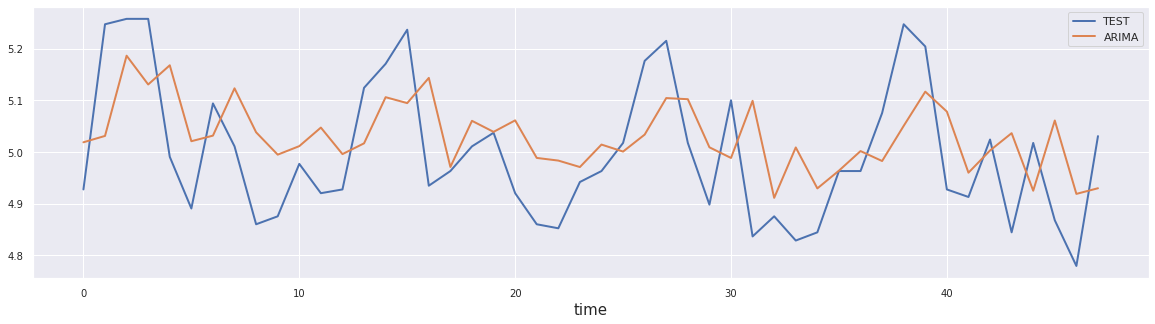

In [32]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

## Modelo SARIMA

Según el análisis de la serie existe un fuerte componente estacional en la producción de cerveza que, como se observó anteriormente, no está siendo capturado por el proceso ARIMA seleccionado. Por consiguiente, se procede a estimar un modelo SARIMA, que es un modelo ARIMA que incluye el componente estacional de las series.

#### Selección proceso SARIMA a estimar

In [49]:
stepwise_model = auto_arima(train, 
                            start_p=0,
                            start_q=0, 
                            max_p=5, 
                            max_d=2, 
                            max_q=5, 
                            start_P=1,
                            start_Q=1, 
                            max_P=2, 
                            max_D=2, 
                            max_Q=2, 
                            max_order=10,
                            m=12,
                            seasonal=True,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-490.740, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-730.501, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-654.380, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-492.714, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-512.047, Time=0.29 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-750.258, Time=1.64 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-647.959, Time=0.99 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-936.418, Time=2.88 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-902.507, Time=1.56 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-954.012, Time=3.52 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

Una vez evaluadas las posibles combinaciones para el proceso SARIMA, el modelo con el mejor performance es el que tiene menor AIC, en este caso es el ARIMA(1,1,1)x(2,0,2,12) con un AIC=-1014.517

#### Estimación modelo

In [51]:


mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  428
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 516.483
Date:                                 Tue, 06 Feb 2024   AIC                          -1018.965
Time:                                         15:32:50   BIC                           -990.568
Sample:                                              0   HQIC                         -1007.749
                                                 - 428                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1559      0.045     -3.491      0.000      -0.243      -0

c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Evaluando el modelo con los parámetros óptimos, se observa que todos los coeficientes del modelo son significativos a excepción de los primeros coeficientes de AR y MA de la parte estacional, sin embargo los mantenemos en el modelo ya que los segundos coeficientes de AR y MA del componente estacional si son significativos.

####  Análisis de residuales

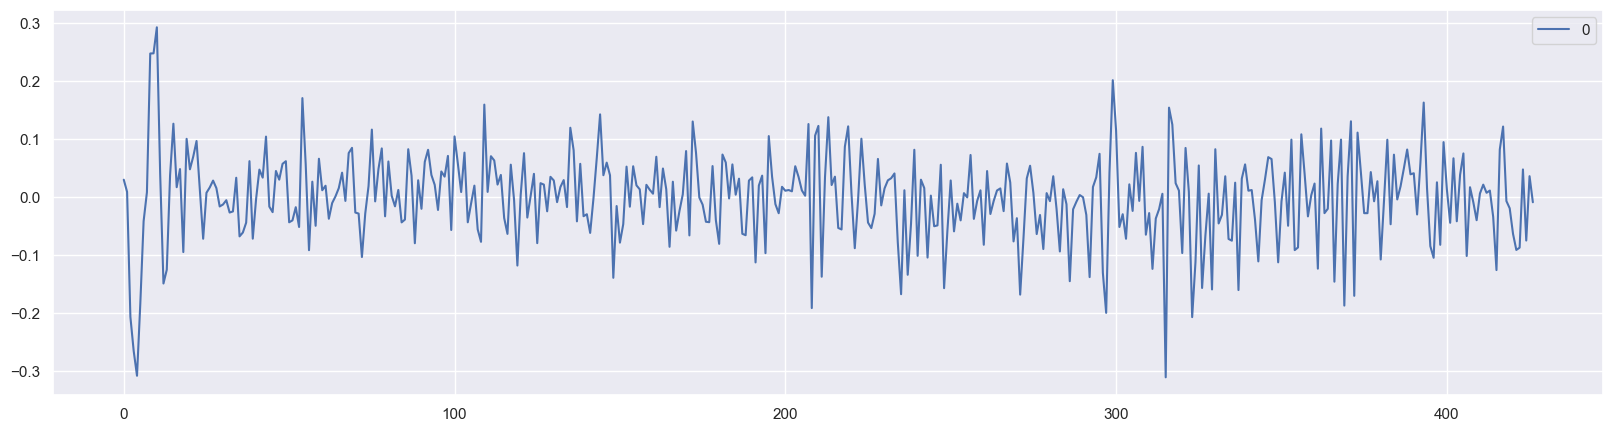

In [52]:
#results.resid
residuals1 = pd.DataFrame(results.resid[1:])
residuals1.plot(figsize=(20,5))
plt.show()

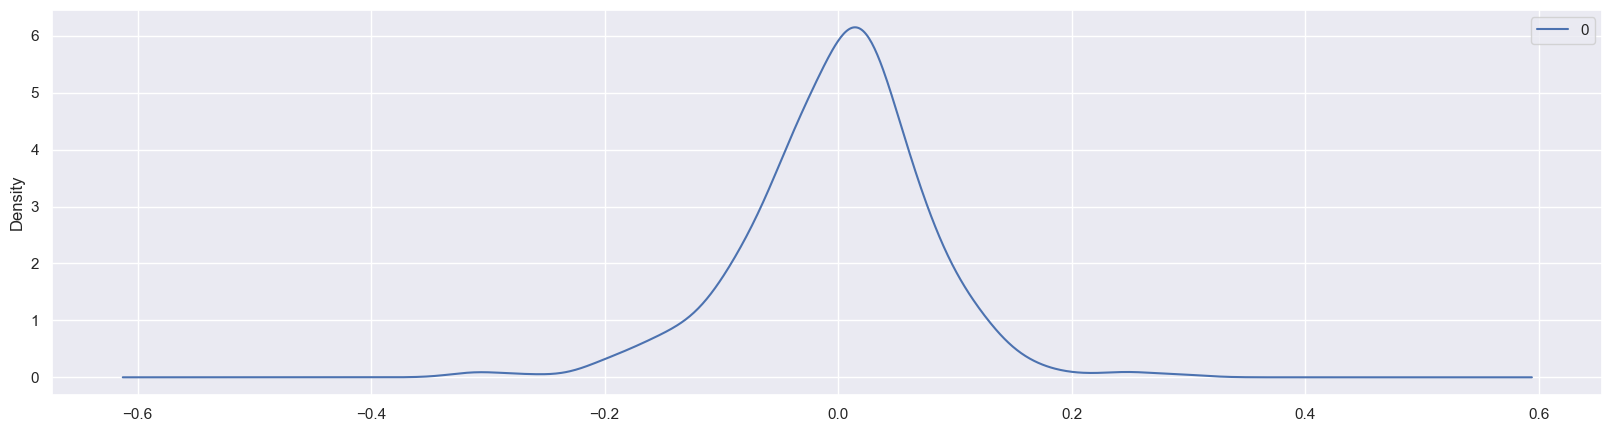

                0
count  427.000000
mean    -0.001296
std      0.076276
min     -0.310979
25%     -0.042121
50%      0.006484
75%      0.041207
max      0.292270


In [53]:
residuals1.plot(kind='kde', figsize=(20,5))
plt.show()
print(residuals1.describe())

In [37]:
print("KS P-value = "+str(round(stats.kstest(residuals1, 'norm')[1], 10)))
print("D’Agostino and Pearson’s P-value = "+str(round(stats.normaltest(residuals1, axis=0)[1][0], 6)))

KS P-value = 0.0
D’Agostino and Pearson’s P-value = 0.0


Según los resultados del test de Kolmogorov Smirnoff con un nivel de significancia del 5% no podemos concluir que los residuales se ajustan a una distribución normal.

#### Rolling Forecast

In [55]:
X = data['Log_Production'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = sm.tsa.statespace.SARIMAX(history, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)


c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\zukan\anaconda3\envs\entornoGPU\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

In [57]:
error_SARIMA = mean_squared_error(test, predictions)**0.5
print('Test RMSE: %.3f' % error_SARIMA)

Test RMSE: 0.063


El mejor modelo SARIMA de los testeados presenta un RMSE sobre los datos de test de 0.062.

In [58]:
RollBack=pd.concat([RollBack,pd.DataFrame({'SARIMA':predictions})],axis=1)
RollBack.head()

,TEST,ARIMA,SARIMA
0,4.927254,4.996508,4.993682
1,5.247024,5.008252,5.181965
2,5.257495,5.166711,5.226994
3,5.257495,5.112389,5.296455
4,4.990433,5.151598,5.110424


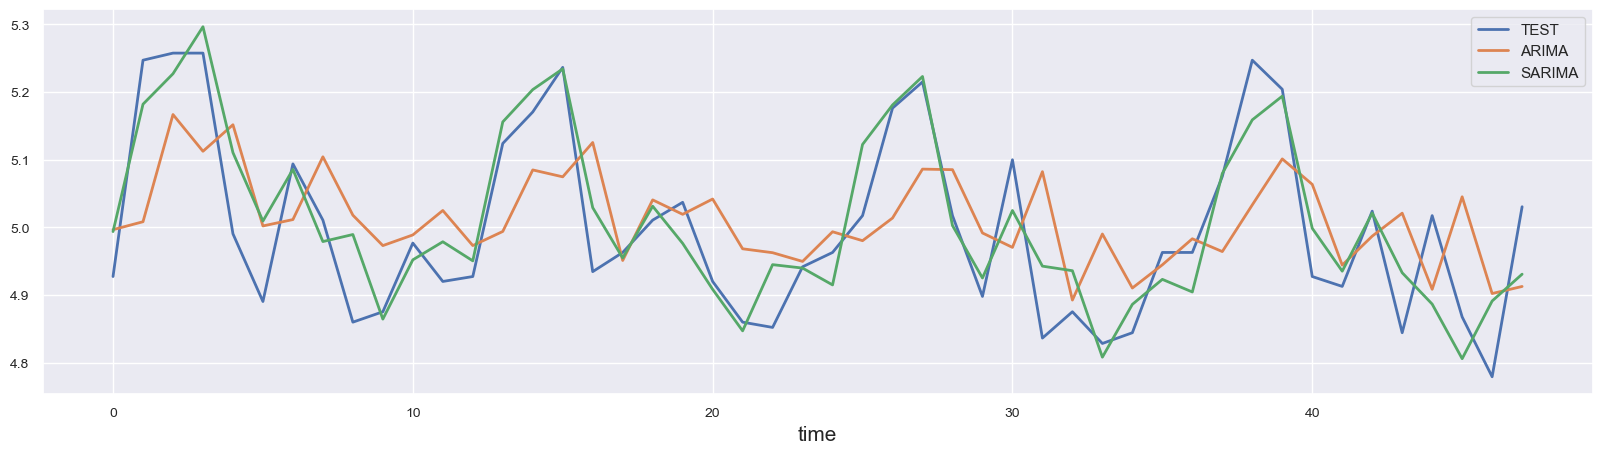

In [59]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

## Prophet Forecast

#### Estimación modelo

In [8]:
data_pf = pd.DataFrame({'ds': data.Log_Production.index[:], 'y': data.Log_Production})
data_pf.head()

,ds,y
Month,,
1956-01-01,1956-01-01,4.534748
1956-02-01,1956-02-01,4.564348
1956-03-01,1956-03-01,4.555980
1956-04-01,1956-04-01,4.345103
1956-05-01,1956-05-01,4.261270


In [9]:
X = data_pf.y
Y = data_pf.ds
size = int(len(X) * 0.9)
train_X, test_X = X[0:size], X[size:len(X)]
train_Y, test_Y = Y[0:size], Y[size:len(Y)]
    
Train = pd.concat([train_Y,train_X], axis=1)
Test = pd.concat([test_Y,test_X], axis=1)

In [10]:
predictions = list()
    
def rolling_forecast():   
    history = Train.copy()
    
    for t in range(len(test_X)):
        m = Prophet()
        m.fit(history);
        future = m.make_future_dataframe(periods=1, freq='MS')
        forecast = m.predict(future)
        output=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        yhat = output[['yhat']][len(history):].values[0][0]
        predictions.append(yhat)
        obs = pd.DataFrame(Test[['ds','y']].iloc[t])
        history = pd.concat([history, obs.transpose()],axis=0)
        print('predicted=%f, expected=%f' % (yhat, obs.transpose()['y']))

    
    error_PROPHET = mean_squared_error(test_X, predictions)**0.5
    print('Test RMSE: %.3f' % error_PROPHET)

In [11]:
rolling_forecast()

predicted=5.036859, expected=4.927254
predicted=5.180717, expected=5.247024
predicted=5.222271, expected=5.257495
predicted=5.309601, expected=5.257495
predicted=5.109395, expected=4.990433
predicted=5.061708, expected=4.890349
predicted=5.114118, expected=5.093750
predicted=5.012357, expected=5.010635
predicted=4.983117, expected=4.859812
predicted=4.844977, expected=4.875197
predicted=4.943017, expected=4.976734
predicted=4.996920, expected=4.919981
predicted=5.039387, expected=4.927254
predicted=5.149326, expected=5.123964
predicted=5.211210, expected=5.170484
predicted=5.285263, expected=5.236442
predicted=5.106950, expected=4.934474
predicted=5.012821, expected=4.962845
predicted=5.095008, expected=5.010635
predicted=4.989577, expected=5.036953
predicted=4.953233, expected=4.919981
predicted=4.832774, expected=4.859812
predicted=4.924845, expected=4.852030
predicted=4.969287, expected=4.941642
predicted=5.005572, expected=4.962845
predicted=5.137448, expected=5.017280
predicted=5.

In [12]:
error_PROPHET = mean_squared_error(test_X, predictions) **0.5
print('Test RMSE: %.3f' % error_PROPHET)

Test RMSE: 0.078


Para el proceso del Rolling Forecast con Prophet separamos la base en train (90% de obs) para estimar el modelo y en test (10%) para calcular el error de la predicción. Dicho esto, escogemos el modelo con menor RMSE el cual es el que predice mejor, en este caso con un RMSE=0.078

In [ ]:
RollBack=pd.concat([RollBack,pd.DataFrame({'Prophet':predictions})],axis=1)
RollBack.head()

In [ ]:
RollBack[['TEST', 'Prophet']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

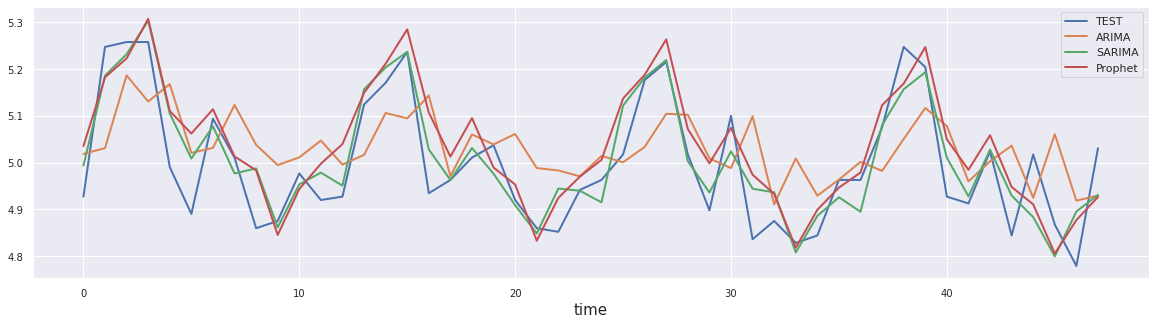

In [49]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

## 4.4. LSTM Forecast

In [28]:
data_LSTM = pd.DataFrame({'Log_Production': data.Log_Production})
data_LSTM.head()

,Log_Production
Month,
1956-01-01,4.534748
1956-02-01,4.564348
1956-03-01,4.555980
1956-04-01,4.345103
1956-05-01,4.261270


In [29]:
Y = data_LSTM
size = int(len(Y) * 0.9)

train_Y, test_Y = Y[0:size], Y[size:len(Y)]



In [30]:
scaler = MinMaxScaler()
scaler.fit(train_Y)
scaled_train_data = scaler.transform(train_Y)
scaled_test_data = scaler.transform(test_Y)

In [31]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [32]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, input_shape=(n_input, n_features)))
#lstm_model.add(LSTM(units=50, return_sequences = True))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [33]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
416/416 [==============================] - 4s 10ms/step - loss: 0.0233
Epoch 2/20
416/416 [==============================] - 4s 9ms/step - loss: 0.0156
Epoch 3/20
416/416 [==============================] - 4s 10ms/step - loss: 0.0105
Epoch 4/20
416/416 [==============================] - 4s 10ms/step - loss: 0.0083
Epoch 5/20
416/416 [==============================] - 5s 11ms/step - loss: 0.0082
Epoch 6/20
416/416 [==============================] - 5s 12ms/step - loss: 0.0080
Epoch 7/20
416/416 [==============================] - 5s 12ms/step - loss: 0.0079
Epoch 8/20
416/416 [==============================] - 5s 12ms/step - loss: 0.0080
Epoch 9/20
416/416 [==============================] - 4s 9ms/step - loss: 0.0066
Epoch 10/20
416/416 [==============================] - 4s 9ms/step - loss: 0.0075
Epoch 11/20
416/416 [==============================] - 4s 9ms/step - loss: 0.0068
Epoch 12/20
416/416 [==============================] - 4s 9ms/step - loss: 0.0069
Epoch 13/20
416/41

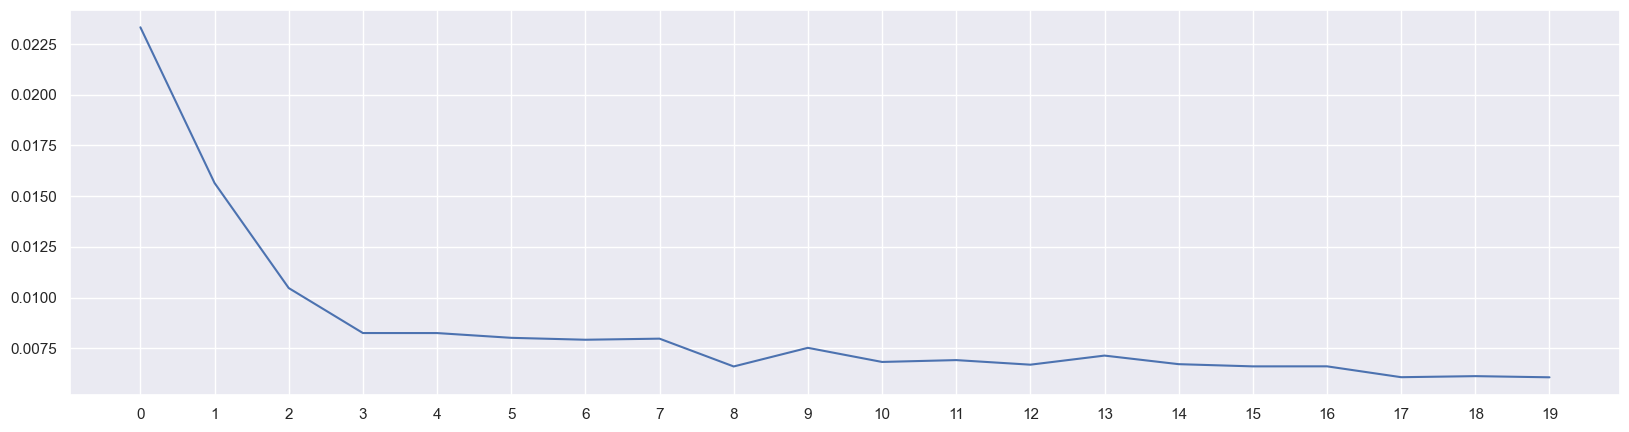

In [34]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(20,5))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [35]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_Y)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [36]:
from tqdm import tqdm

lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in tqdm(range(len(test_Y))):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)


100%|██████████| 48/48 [00:00<00:00, 368.82it/s]


In [37]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [39]:
error_LSTM = mean_squared_error(test_Y, lstm_predictions) ** 0.5
print('Test RMSE: %.3f' % error_LSTM)

Test RMSE: 0.130


In [60]:
RollBack = pd.concat([RollBack,pd.DataFrame({'LSTM':np.concatenate(lstm_predictions, axis=0)})],axis=1)
RollBack.head()

,TEST,ARIMA,SARIMA,Prophet,LSTM
0,4.927254,5.018556,4.993731,5.035216,4.979422
1,5.247024,5.030858,5.185549,5.182063,5.095238
2,5.257495,5.186171,5.231601,5.222644,5.126276
3,5.257495,5.130449,5.303089,5.307011,5.103798
4,4.990433,5.167606,5.105022,5.110226,5.050446


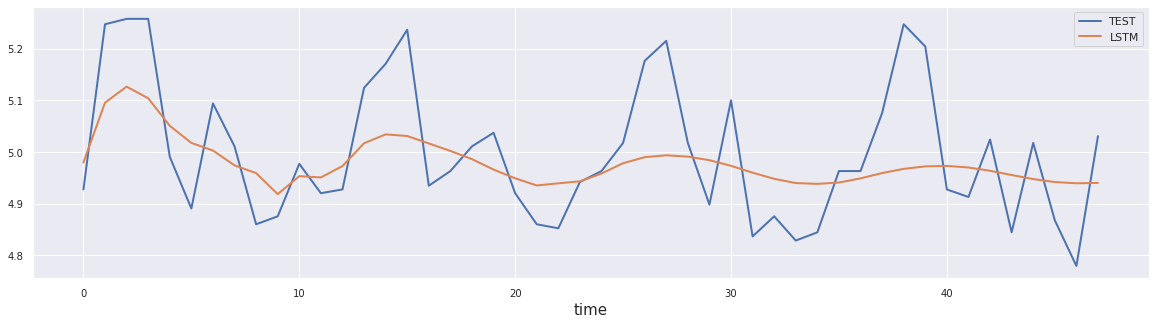

In [61]:
RollBack[['TEST', 'LSTM']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

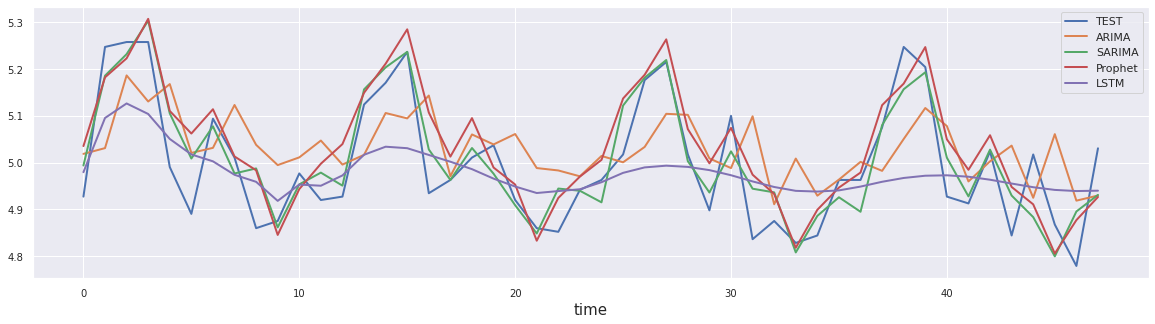

In [62]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

# 5. Conclusiones

In [63]:
RollBack = pd.concat([RollBack,pd.DataFrame({'Time':data.Log_Production.index[size:]})],axis=1)
RollBack.head()

,TEST,ARIMA,SARIMA,Prophet,LSTM,Time
0,4.927254,5.018556,4.993731,5.035216,4.979422,1991-09-01
1,5.247024,5.030858,5.185549,5.182063,5.095238,1991-10-01
2,5.257495,5.186171,5.231601,5.222644,5.126276,1991-11-01
3,5.257495,5.130449,5.303089,5.307011,5.103798,1991-12-01
4,4.990433,5.167606,5.105022,5.110226,5.050446,1992-01-01


In [64]:
RollBack.set_index('Time', inplace=True)
RollBack.head()

,TEST,ARIMA,SARIMA,Prophet,LSTM
Time,,,,,
1991-09-01,4.927254,5.018556,4.993731,5.035216,4.979422
1991-10-01,5.247024,5.030858,5.185549,5.182063,5.095238
1991-11-01,5.257495,5.186171,5.231601,5.222644,5.126276
1991-12-01,5.257495,5.130449,5.303089,5.307011,5.103798
1992-01-01,4.990433,5.167606,5.105022,5.110226,5.050446


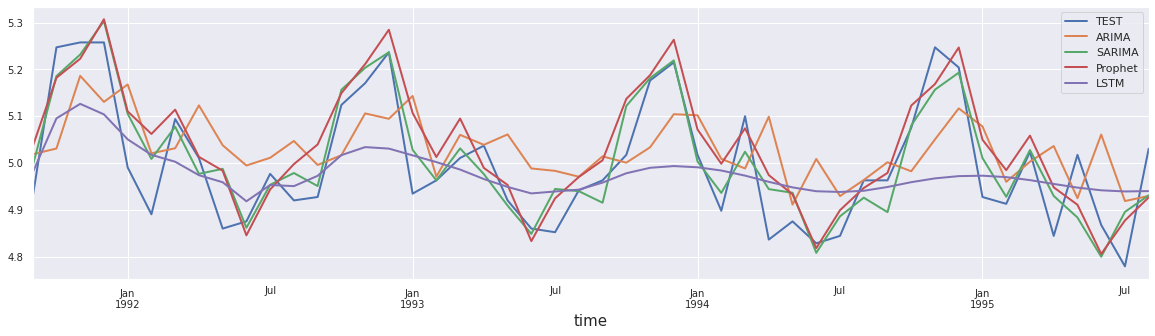

In [65]:
RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

In [66]:
Error = pd.DataFrame({"Models":["ARIMA", "SARIMA", "Prophet", "LSTM"],
                      "RMSE Log" : [error_ARIMA, error_SARIMA, error_PROPHET, error_LSTM]})
Error

,Models,RMSE Log
0,ARIMA,0.122232
1,SARIMA,0.064094
2,Prophet,0.077715
3,LSTM,0.109442


In [67]:
print('Test RMSE ARIMA: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.ARIMA)))
print('Test RMSE SARIMA: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.SARIMA)))
print('Test RMSE Prophet: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.Prophet)))
print('Test RMSE LSTM: %.3f' % mean_squared_error(np.exp(RollBack.TEST), np.exp(RollBack.LSTM)))

Test RMSE ARIMA: 347.425
Test RMSE SARIMA: 87.175
Test RMSE Prophet: 133.123
Test RMSE LSTM: 296.710


Al comparar los RMSE obtenidos en las diferentes estimaciones, se obtiene que el Modelo SARIMA arroja el menor RSME (84.416), seguido del Modelo Prophet (RSME = 133.123). Por otra parte, cuando se grafican la series estimadas versus la observada, se encuentra que la serie resultado de los modelos Prophet y SARIMA son los de mejo ajuste a la serie de análisis. Sin embargo, los residuales del modelo SARIMA no se distribuyen normal. Por lo cual recomendamos el uso del modelo Prophet que no requiere de este supuesto para la realización de pronósticos de la producción de cerveza.

En términos de negocio, debido a la misma naturaleza del mercado de Cervezas, es importante  tener una buena predicción especialmente para los periodos estacionales, ya que son los de mayor foco para lanzamientos de nuevas marcas o campañas específicas. Dicho esto, el modelo SARIMA funciona mejor pero tendríamos que hacer alguna transformación o corrección en los datos train para garantizar la normalidad en los residuales, debido a esto se recomienda utilizar el modelo Prophet.

En términos de Escalabilidad tanto el modelo Prophet como el SARIMA funcionan muy bien, ya que el algoritmo en su proceso iterativo evalúa múltiples modelos, eligiendo el de mejor performance. Podría ser muy interesante para los Fabricantes aplicar estos modelos en Datos de más países donde tienen participación, ya que en general la naturaleza de los datos se mantiene en los diferentes países.

En cuanto al procesamiento, consume menos hardware procesar el prophet que el modelo SARIMA, así mismo, al medir sus tiempos de ejecución el modelo SARIMA consume más tiempo de ejecución que el Prophet

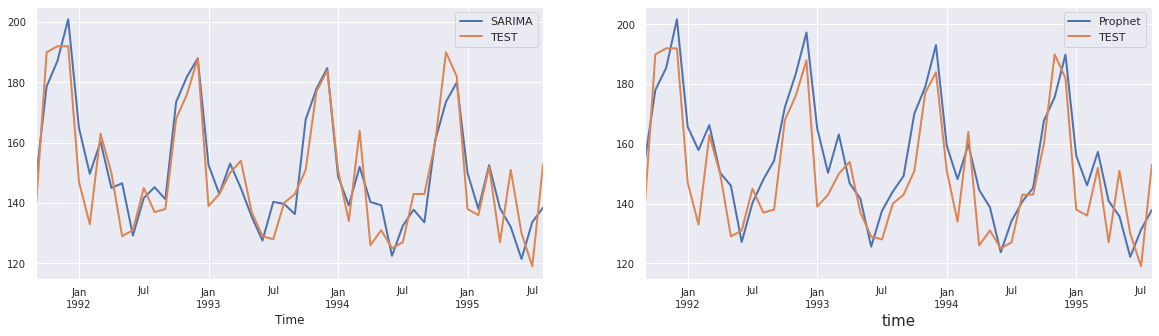

In [68]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
np.exp(RollBack[['SARIMA','TEST']]).plot(figsize=(20,5), linewidth=2, fontsize=10, ax = ax[0])
np.exp(RollBack[['Prophet','TEST']]).plot(figsize=(20,5), linewidth=2, fontsize=10, ax = ax[1])
plt.xlabel('time', fontsize=15);
#plt.show()